# Trying the gluonts rolling window module

In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model,preprocessing
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
locations = list(df.location.unique())[:10]
#Process the df into a uniformly spaced df
one_ts_df = df.loc[df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq)

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

100%|██████████| 50/50 [00:05<00:00,  9.64it/s, epoch=4/4, avg_epoch_loss=0.733]


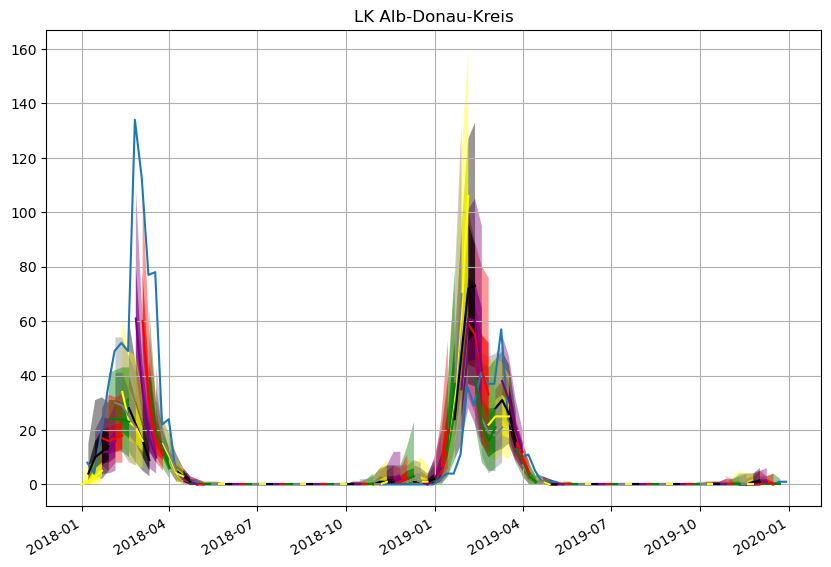

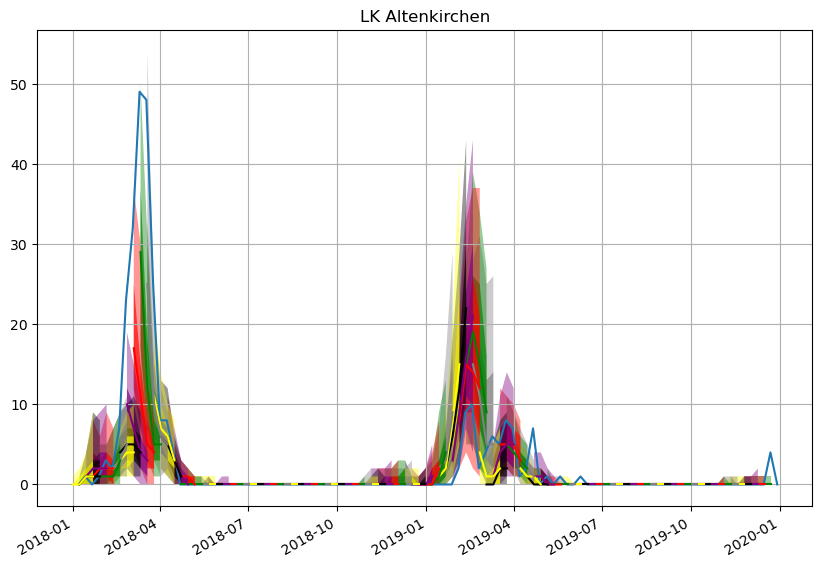

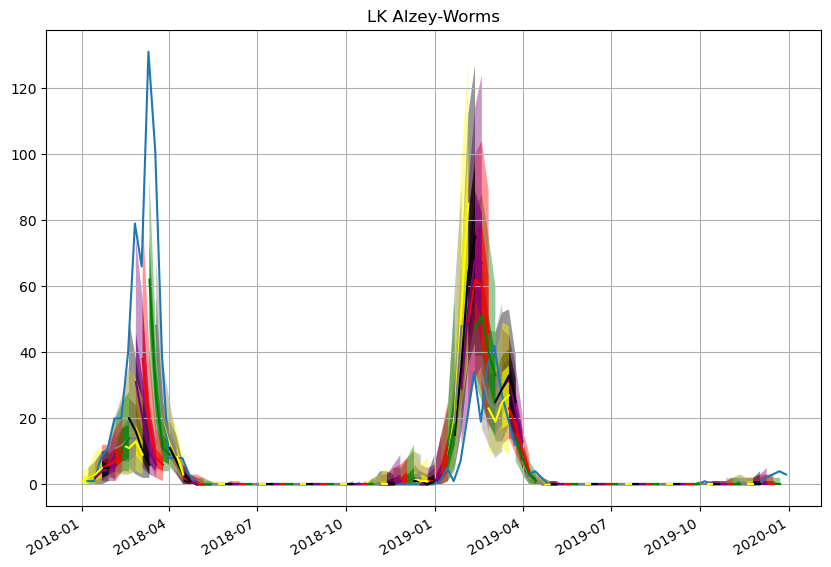

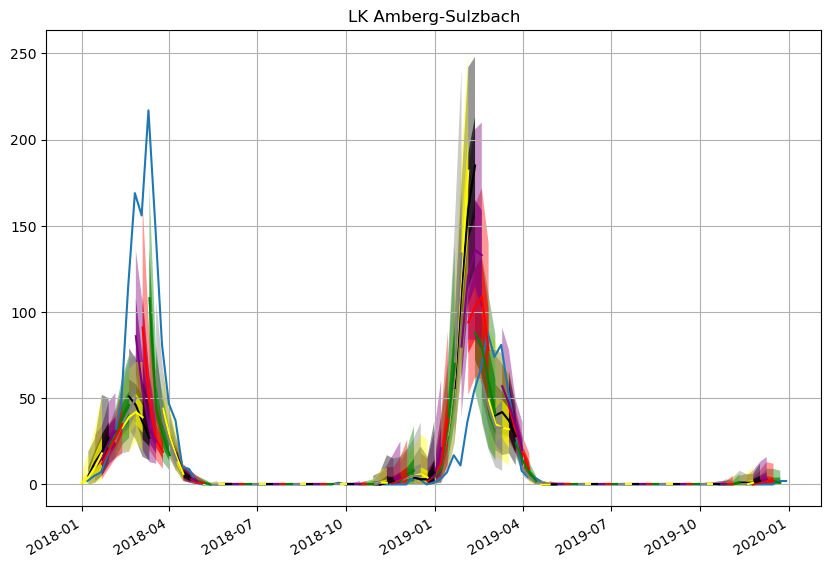

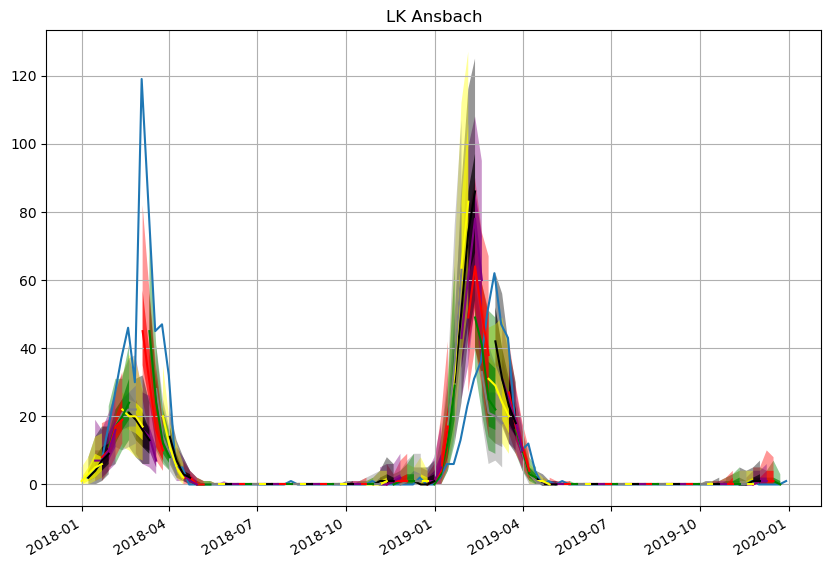

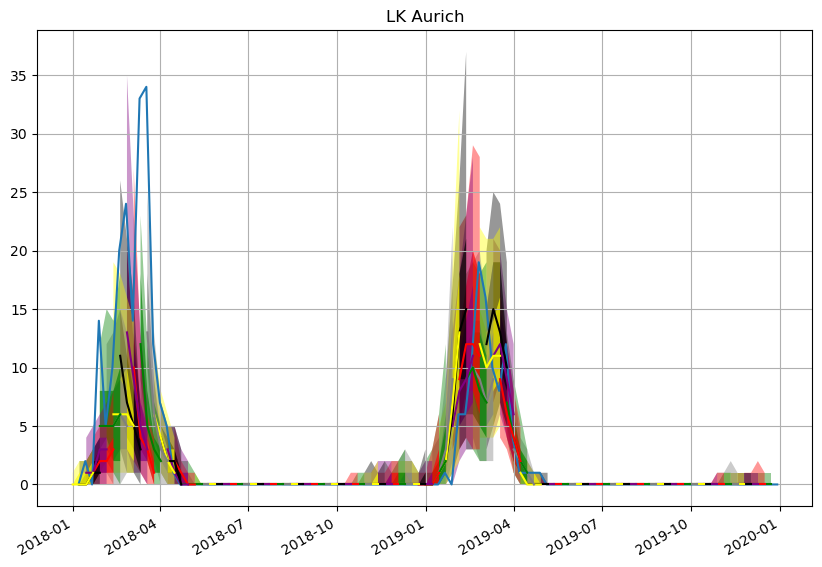

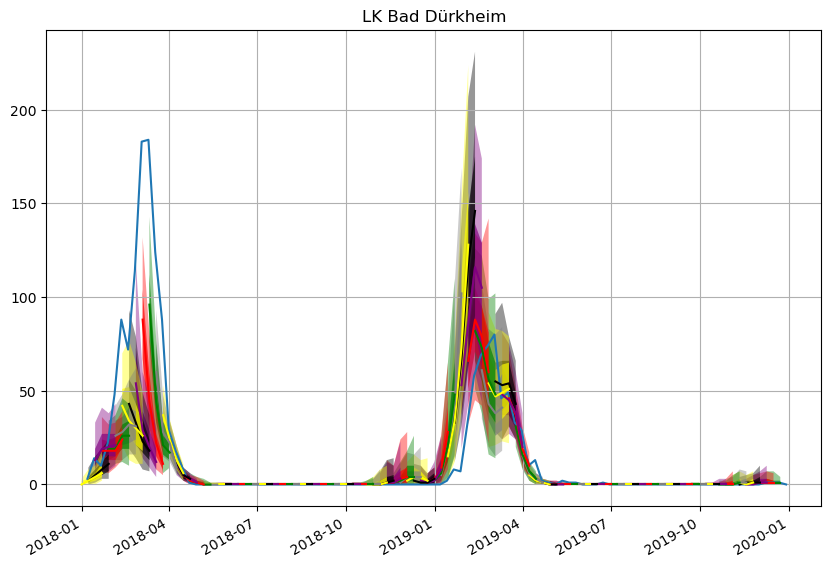

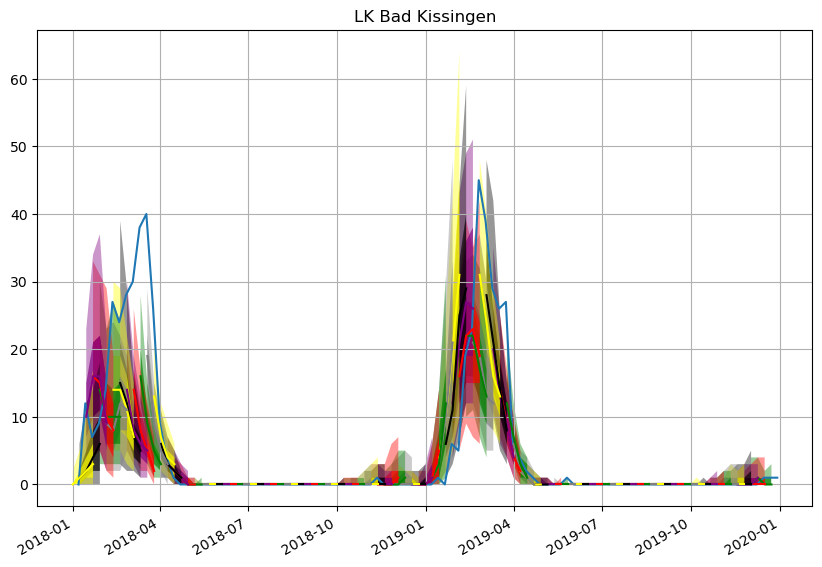

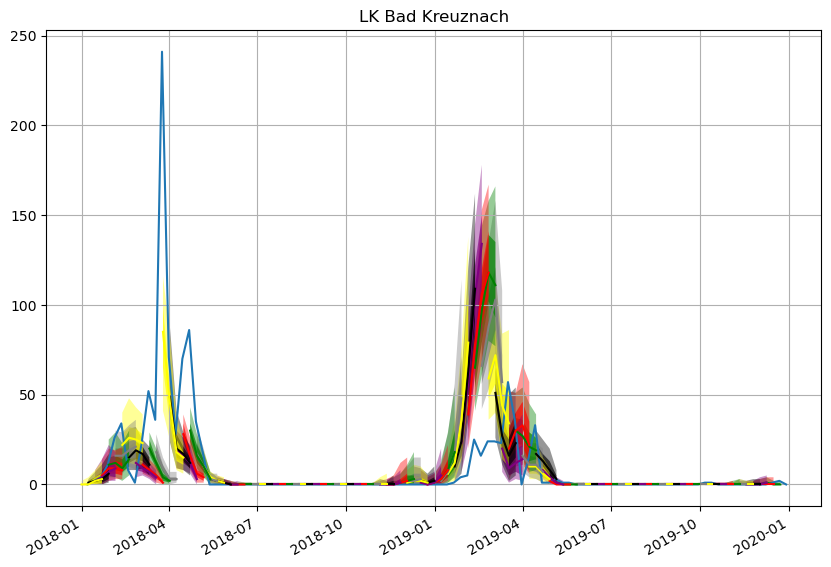

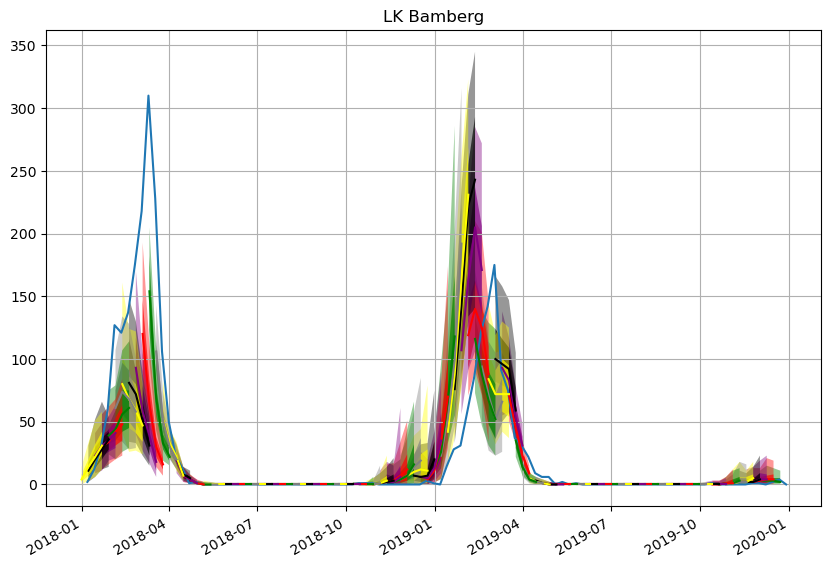

In [3]:
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:10]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

In [4]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=config.quantiles)
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(item_metrics[item_metrics.item_id == "LK Bad Dürkheim"])

Running evaluation: 1010it [00:00, 1936.84it/s]


             item_id         forecast_start          MSE  abs_error  \
606  LK Bad Dürkheim  2019-12-02/2019-12-08     1.048625        1.0   
607  LK Bad Dürkheim  2019-11-25/2019-12-01     0.913500        1.0   
608  LK Bad Dürkheim  2019-11-18/2019-11-24     1.291075        0.0   
609  LK Bad Dürkheim  2019-11-11/2019-11-17     2.126150        2.0   
610  LK Bad Dürkheim  2019-11-04/2019-11-10     2.161650        2.0   
..               ...                    ...          ...        ...   
702  LK Bad Dürkheim  2018-01-29/2018-02-04  3780.127930      232.0   
703  LK Bad Dürkheim  2018-01-22/2018-01-28  1955.098877      152.0   
704  LK Bad Dürkheim  2018-01-15/2018-01-21  1263.990234      101.0   
705  LK Bad Dürkheim  2018-01-08/2018-01-14   397.335327       68.0   
706  LK Bad Dürkheim  2018-01-01/2018-01-07    93.977257       37.0   

     abs_target_sum  abs_target_mean  seasonal_error       MASE      MAPE  \
606             3.0             0.75        2.324056   0.107571  0.000

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
